# Language Classification

This notebook describes the use three models: 1) a Decision Tree, 2) Random Forest, and 3) Gradient Boost for language detection with the aim of classifying text into either English, Afrikaans or Dutch.

### Import Python Libraries

In [1]:
import numpy as np # For arithmetics and arrays
import math # For inbuilt math functions
import pandas as pd # For handling data frames
import collections # used for dictionaries and counters
from itertools import permutations # used to find permutations

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function to easily split data into training and testing samples
from sklearn.decomposition import PCA # Principal component analysis used to reduce the number of features in a model
from sklearn.preprocessing import StandardScaler # used to scale data to be used in the model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import pickle # To save the trained model and then read it

import seaborn as sns # Create plots
sns.set(style="ticks")
import matplotlib.pyplot as plt # Create plots

import warnings
warnings.filterwarnings('ignore')

### Read and Clean Data 
- The data is cleaned from null values and formatted appropriately for analysis.
- Several observations have an empty value for the "text" column but are assigned a language. Since a null value can be found in any language and cannot be differentiated on any feature, we exclude them from the data.

In [2]:
df = pd.read_csv('lang_data.csv') # Read raw data
df = df.dropna() # remove null values for the "text" column
df['text'] = df['text'].astype(str) # Convert the column "text" from object to a string in order to operate on it
df['language'] = df['language'].astype(str)

### Create a Set of Features
I create a set of features that will be used in the model for classifying text into three languages: English, Afrikaans, and Dutch. The following features are used:
- **word_count**: Counts the words in each text observation. If the text input represents a sentence then the latter in some languages may have a tendency to be composed of more words.
- **character_count**: Counts the number of non-space characters. Sentences or words in some languages may generally have more characters.
- **word_density**: Divides the word_count by the character_count and creates an average relative relation between the latter two variables. This feature standardizes the length of a word based on how many words and characters there are in a text input.
- **punc_count**: Counts the number of punctuations in a text input. Some languages may use more punctuations.
- **v_char_count**: Counts the number of times the letter "v" is used in a text. In Afrikaans "w" and "v" are merged to become a voiced “v”. Ex: "vɛrk": Afrikaans, "wɛrk" in Dutch.
- **w_char_count**: Counts the number of times the letter "w" is used in a text.
- **ij_char_count**: Counts the number of times "ij" is repeated in the text. Typically found in Dutch language.
- **num_double_consec_vowels**: Counts the number of same consecutive vowels in a text. Both Afrikaans and Dutch are more likely to have same consecutive vowels.
- **num_consec_vowels**: Counts the number of different consecutive vowels in a text. Both Afrikaans and Dutch are more likely to have same consecutive vowels. Moreover, when "g" or "v" appear between vowels, they are dropped in Afrikaans as opposed to Dutch.
- **num_vowels**: Number of vowels in a text.
- **vowel_density**: Standardizes the number of vowels to the number of words in a text.
- **capitals**: Counts the number of capital letters used in a text. Some languages may make use of more capital letters.
- **caps_vs_length**: Standardizes the number of capital letters used to the total number of characters in a text.
- **num_exclamation_marks**: Counts the number of exclamation marks in a text. Some languages may use more exclamation marks.
- **num_question_marks**: Counts the number of question marks in a text. Some languages may use more question marks.
- **num_punctuation**: Counts the number of punctuations in a text. Some languages may use more punctuation.
- **num_unique_words**: Counts the number of unique words in a text. Some languages may use more unique words.
- **num_repeated_words**: Counts the number of repeated words in a text. Some languages may repeat words more often.
- **words_vs_unique**: Standadizes the  number of unique words to the number of words in a text.
- **encode_ascii**: Checks whether a text can be encoded using utf-8, which uses English characters. This feature will more likely be true for English text.

In [3]:
# Define a list of commonly found punctuations
punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
vowels=['a','e','i','o','u']
# Define a list of double consecutive vowels which are typically found in Dutch and Afrikaans languages
same_consecutive_vowels = ['aa','ee', 'ii', 'oo', 'uu'] 
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
dutch_combos = ['ij']

# Create a pre-defined set of features based on the "text" column in order to allow us to characterize the string
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))
df['v_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'v']))
df['w_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'w']))
df['ij_char_count'] = df['text'].apply(lambda x : sum([any(d_c in a for d_c in dutch_combos) for a in x.split()]))
df['num_double_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in same_consecutive_vowels) for a in x.split()]))
df['num_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))
df['num_vowels'] = df['text'].apply(lambda x : sum([any(v in a for v in vowels) for a in x.split()]))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['character_count']),axis=1)
df['num_exclamation_marks'] =df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in punc))
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['text'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))
df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
df['encode_ascii'] = np.nan
for i in range(len(df)):
    try:
        df['text'].iloc[i].encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        df['encode_ascii'].iloc[i] = 0
    else:
        df['encode_ascii'].iloc[i] = 1

### Summarize Features

In [4]:
# This table shows the average of each feature per language. 
# It allows us to do a quick check to see if there are significant difference in the features among the languages.
df.groupby('language').mean().T

language,Afrikaans,English,Nederlands
word_count,10.503912,4.072506,5.746269
character_count,43.541471,16.841849,26.074627
word_density,0.234060,0.226490,0.209378
punc_count,1.507042,0.317275,1.223881
v_char_count,0.652582,0.126521,0.358209
w_char_count,0.904538,0.291971,0.522388
ij_char_count,0.000000,0.000000,0.268657
num_double_consec_vowels,1.696401,0.178589,1.014925
num_consec_vowels,2.773083,0.536253,1.134328
num_vowels,9.114241,3.742579,5.671642


### Correlation Matrix
- I use a correlation matrix in order to check how correlated the features are to determine their uniqueness. 
- I find that several of the features are highly positively or negatively correlated.

In [5]:
df.corr(method ='pearson') 

,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,ij_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
word_count,1.000000,0.963818,0.284142,0.656144,0.499937,0.576566,0.002617,0.714460,0.769932,0.985911,-0.158172,0.408048,-0.449626,0.161356,0.054530,0.656144,0.985286,0.785662,-0.609634,-0.500432
character_count,0.963818,1.000000,0.066516,0.685772,0.535066,0.579176,0.012066,0.737948,0.801404,0.960918,-0.089117,0.409393,-0.486624,0.174488,0.065903,0.685772,0.950250,0.751124,-0.570829,-0.506098
word_density,0.284142,0.066516,1.000000,0.001107,0.002239,0.061311,-0.032624,0.050620,0.042554,0.249241,-0.356830,0.081018,0.062398,-0.011030,0.001162,0.001107,0.306803,0.143736,-0.178659,-0.077037
punc_count,0.656144,0.685772,0.001107,1.000000,0.370564,0.374964,0.042030,0.548477,0.563451,0.621920,-0.228459,0.385474,-0.287332,0.205043,0.119390,1.000000,0.652952,0.487491,-0.379424,-0.392489
v_char_count,0.499937,0.535066,0.002239,0.370564,1.000000,0.233034,0.022992,0.389565,0.424615,0.499093,-0.038331,0.250590,-0.249199,0.095870,0.025231,0.370564,0.502898,0.367544,-0.287014,-0.337758
w_char_count,0.576566,0.579176,0.061311,0.374964,0.233034,1.000000,0.005225,0.468219,0.413632,0.580779,-0.002004,0.204286,-0.280512,0.111205,0.101982,0.374964,0.562223,0.464511,-0.353433,-0.298730
ij_char_count,0.002617,0.012066,-0.032624,0.042030,0.022992,0.005225,1.000000,0.000365,-0.010899,0.012548,0.047971,-0.021422,-0.048555,-0.007353,-0.007675,0.042030,0.007278,-0.016064,0.017089,0.023861
num_double_consec_vowels,0.714460,0.737948,0.050620,0.548477,0.389565,0.468219,0.000365,1.000000,0.588212,0.707235,-0.079424,0.245026,-0.352140,0.174573,0.040402,0.548477,0.705972,0.563045,-0.412084,-0.471362
num_consec_vowels,0.769932,0.801404,0.042554,0.563451,0.424615,0.413632,-0.010899,0.588212,1.000000,0.776344,-0.044574,0.286679,-0.401469,0.121268,0.033055,0.563451,0.759246,0.604320,-0.452598,-0.436547
num_vowels,0.985911,0.960918,0.249241,0.621920,0.499093,0.580779,0.012548,0.707235,0.776344,1.000000,-0.022570,0.357889,-0.480243,0.158128,0.057858,0.621920,0.968959,0.782950,-0.614507,-0.450493


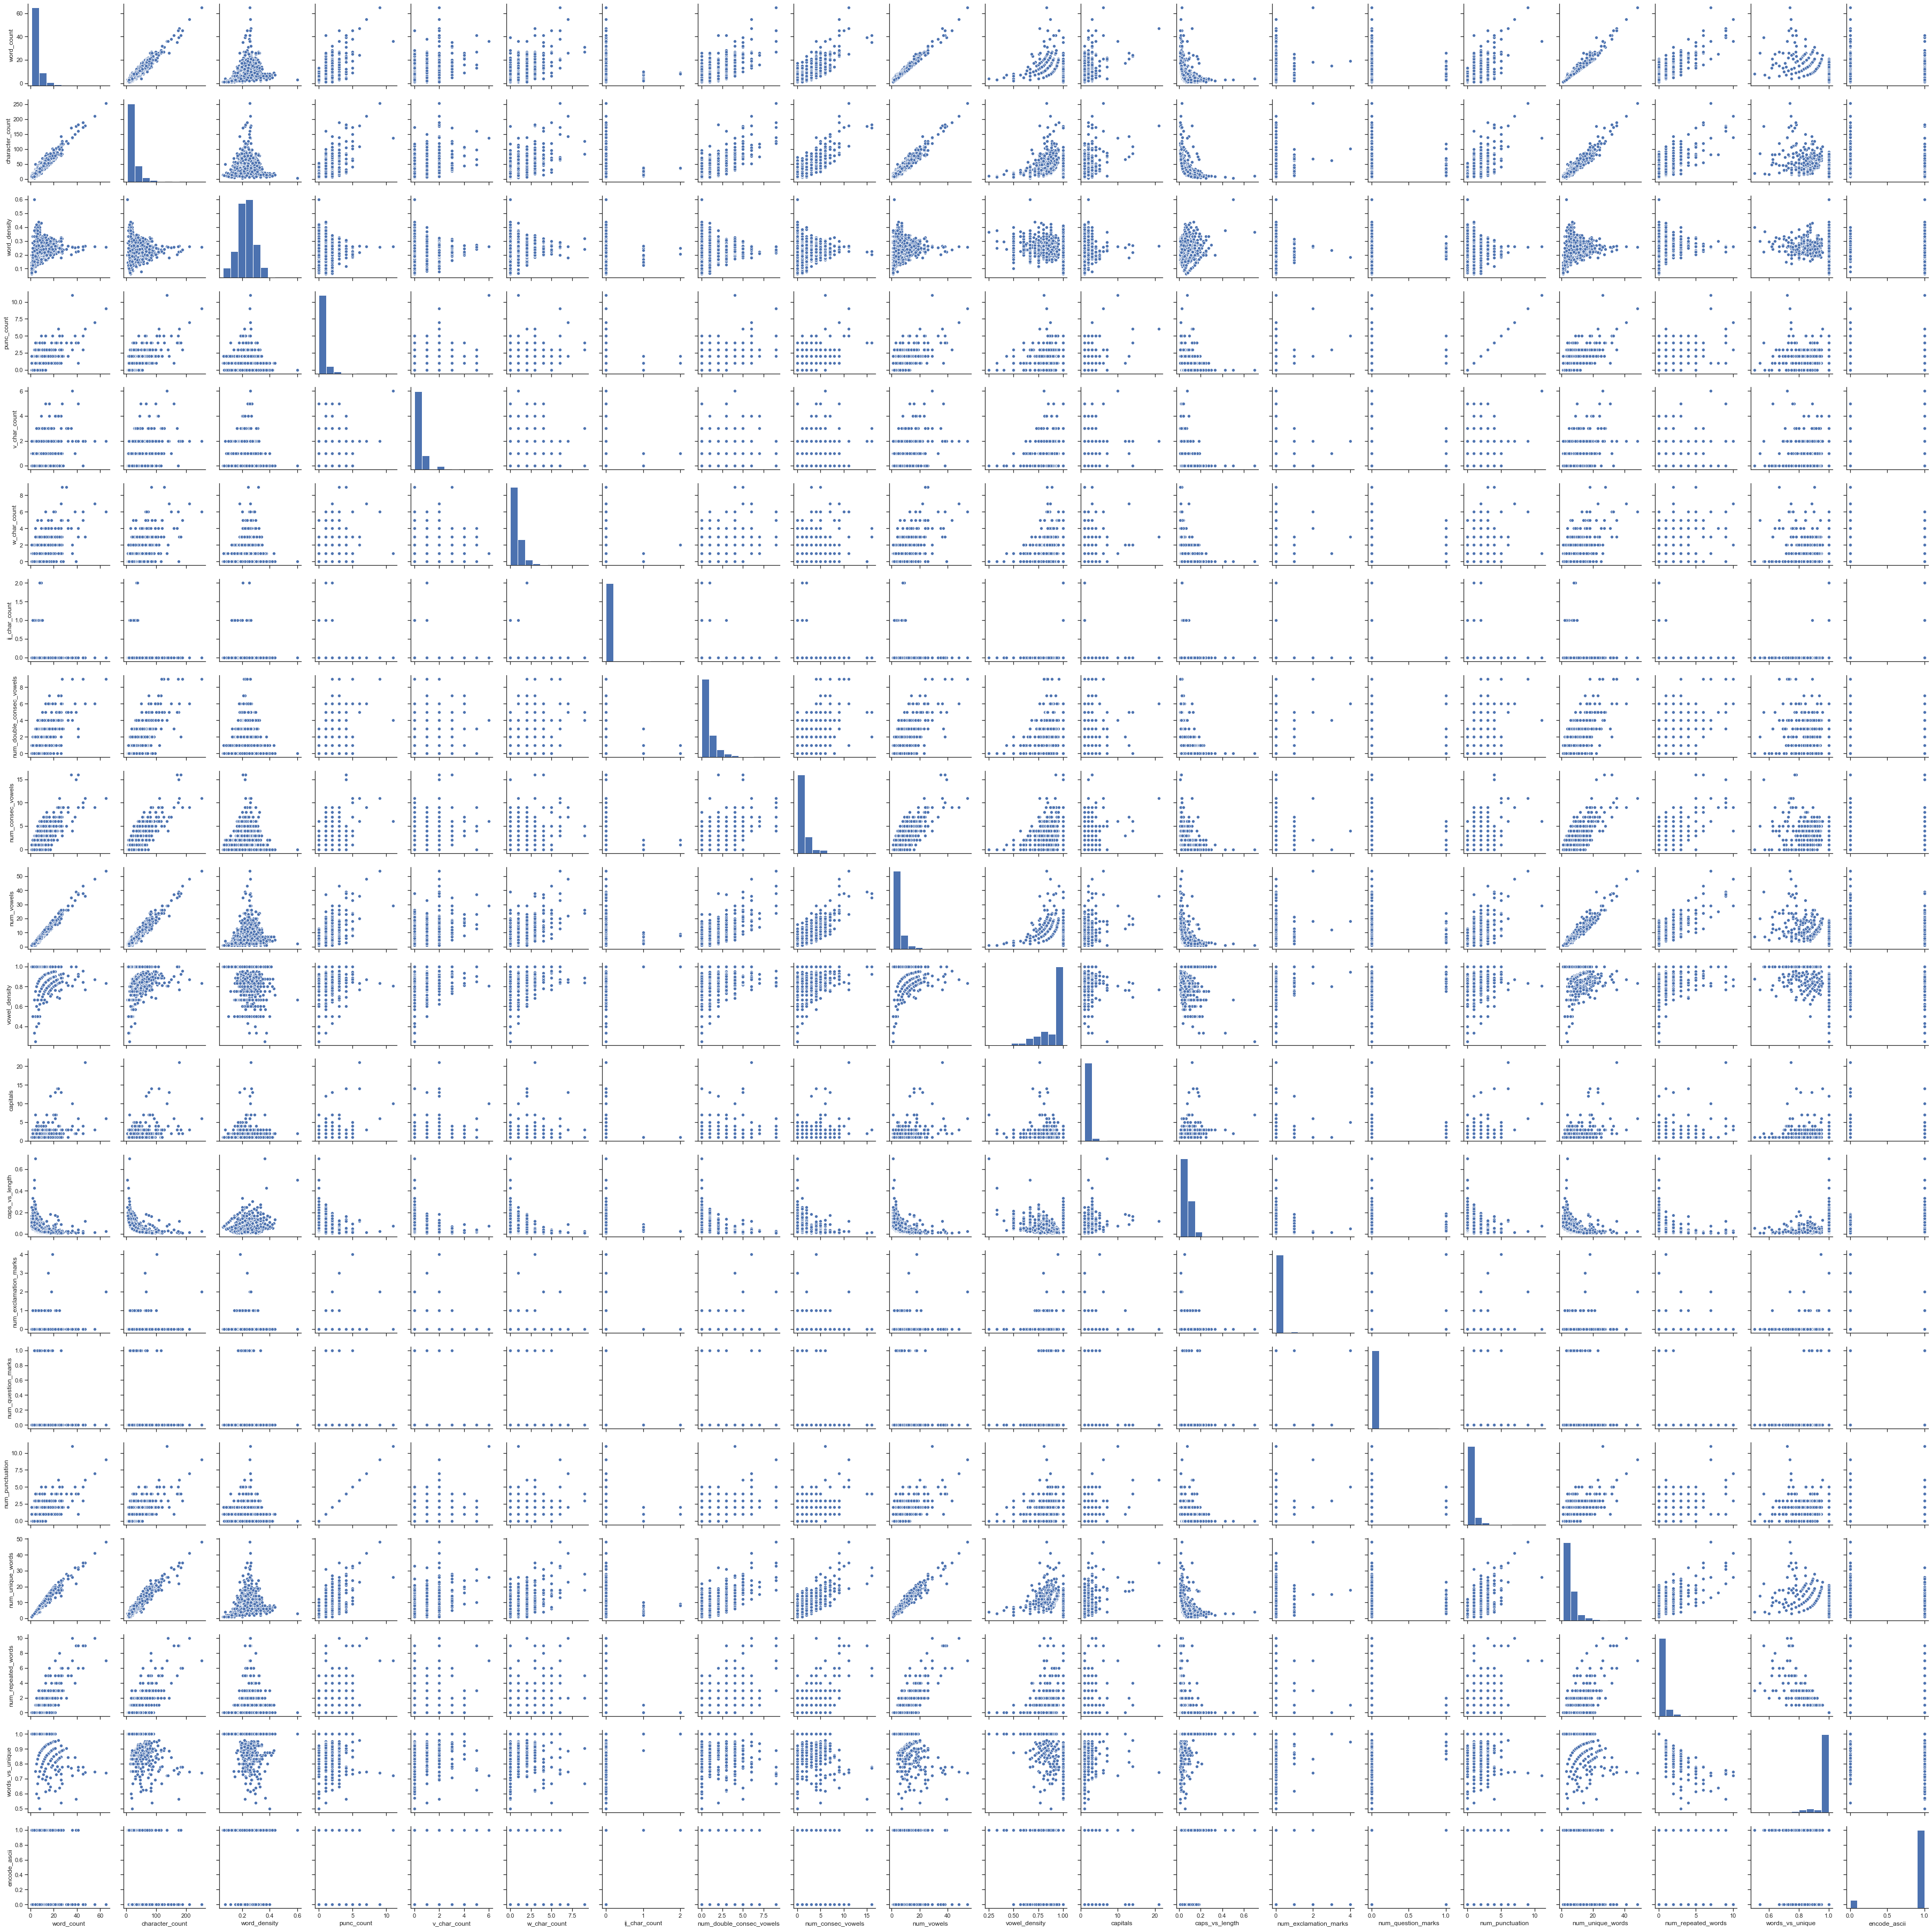

In [6]:
'''In order to visualize the above correlation matrix, I plot the pairwise correlations and find obvious
relationships among the variables from positive and negative correlations, to heteroskedasticity, 
to non-linear relations.'''
sns.pairplot(df)

## Training and Testing Sets
- First, I create the features based on the 'text' column on all the data set.
- Next, I split the data set into 80% training and 20% testing sets. Other percentage splits can be used but these values are typically used.
- The training set will be used to create the model and store its parameters, which will be tested for robustness on the testing set.

In [7]:
#split dataset into features and target variable
feature_cols = list(df.columns)[2:]
X = df[feature_cols] # Features
y = df[['language']] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% train and 20% test

## Reducing Correlation Among Features - PCA

- Given the high correlation between some of the features, I use PCA to create a set of new features.
- PCA converts a set of correlated variables into a set of linearly uncorrelated variables called principal components, which can then be used in models without potentially violating assumptions of multicollinearity.
- In order to use PCA, I first scale the data since PCA is affected by scale.
- I fit the scaler on the training features set and transform both the training and testing features sets.

In [8]:
# Standardize the data
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Transform both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

- Next, I fit PCA on the scaled training features and then transform the scaled training and testing features sets.
- I require that the principal components generated by PCA retain 95% of the variance in the original set of features.

In [9]:
# Make an instance of the model to retain 95% of the variance within the old features.
pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
# PCA has reduced the number of features to 13
print('Number of Principal Components = '+str(pca.n_components_))

Number of Principal Components = 13


In [11]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Model 1: Decision Tree

- Decision trees are simple yet very powerful for classification problems. 
- Each node of the tree denotes a test on an attribute and each branch from that node represents an outcome of the test. Each subsequent leaf node (i.e. terminal node) holds a class label.

- A decision tree model learns by splitting the training set into subsets based on an attribute value test, and this process is repeated on recursive partitions until the subset at a node has the same value of the target parameter, or when additional splitting does not improve on the model's predictive ability.

- The advantages of decision tree models in classification problems are:
    - easy to understand;
    - low computation power;
    - provide clear indication of the most significant parameters for classification.

In [12]:
dt_clf = DecisionTreeClassifier() # Create Decision Tree classifer object
dt_clf = dt_clf.fit(X_train,y_train) # Fit/Train Decision Tree Classifer on training set

# Save model to file in the current working directory so that it can be imported and used.
# I use the pickle library to save the parameters of the trained model
pkl_file = "decision_tree_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(dt_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    dt_clf = pickle.load(file)

dt_clf # parameters of the Decision Tree model are shown below and can be further optimized to improve model performance

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
y_pred = dt_clf.predict(X_test) #Predict the response for test dataset

## Measure Model Performance


### Accuracy
- Accuracy is the ratio of number of correct predictions to the total number of input samples.
- This metric works well when there are equal number of samples belonging to each class, (which is not the case here).

In [14]:
# Calculate accuracy of the Decision Tree Model
accuracy_score_dt = accuracy_score(y_test, y_pred)
print('Accuracy of the Decision Tree Model on the test set = ' + str(round(accuracy_score_dt*100,2)) +"%" )

Accuracy of the Decision Tree Model on the test set = 89.15%


### Confusion Matrix
- The confusion matrix summarizes prediction results in a classification problem.
- The count of correct and incorrect predictions are broken down by each class or label.


In [15]:
labels = ['English', 'Afrikaans', 'Nederlands']
# Confusion Matrix is often used to describe the performance of a classification model 
cm_Model_dt = confusion_matrix(y_test, y_pred, labels)

Text(0.5, 1.0, 'Decision Tree Model Accuracy Score = 89.15%')

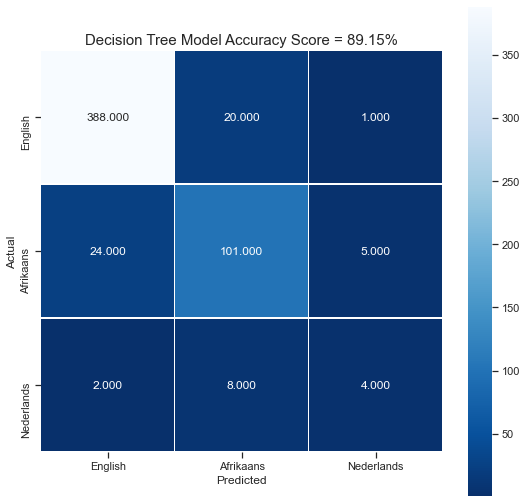

In [16]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(cm_Model_dt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
title = 'Decision Tree Model Accuracy Score = '+ str(round(accuracy_score_dt*100,2)) +"%"
plt.title(title, size = 15)

### Precision, Recall, F-measure, and Support
I also compute the precision, recall, F-measure and support where, tp is the number of true positives, fp the number of false positives, fn the number of false negatives such that:
- precision = tp / (tp + fp)
- recall = tp / (tp + fn)
- F-beta score: weighted harmonic mean of the precision and recall, where an F-beta close to 1 indicates a good fit, and a value close to 0 indicating a bad fit.
- support = number of occurrences of each class in y_test.

In [17]:
print('Decision Tree Model Output')
print(classification_report(y_test,y_pred))

Decision Tree Model Output
              precision    recall  f1-score   support

   Afrikaans       0.78      0.78      0.78       130
     English       0.94      0.95      0.94       409
  Nederlands       0.40      0.29      0.33        14

    accuracy                           0.89       553
   macro avg       0.71      0.67      0.69       553
weighted avg       0.89      0.89      0.89       553



## Model 2: Random Forest

- A Random Forest consists of a large number of individual decision trees that operate together as an ensemble. 
- Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes the model’s prediction.
- The advantage of a Random Forest is that a large number of relatively uncorrelated models or trees operating together will likely outperform any individual constituent model or tree. The benefit from the ensemble decision is that the trees protect each other from their individual errors, as long as they do not constantly generate an error together.

In [18]:
rf_clf = RandomForestClassifier(n_estimators=100) # Create Random Forest classifer object
rf_clf = rf_clf.fit(X_train,y_train) # Fit/Train Random Forest Classifer on training set

# Save model to file in the current working directory so that it can be imported and used.
pkl_file = "random_forest_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(rf_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    rf_clf = pickle.load(file)
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
y_pred = rf_clf.predict(X_test) #Predict the response for test dataset

## Measure Model Performance

### Accuracy

In [20]:
# Calculate accuracy of the Random Forest Model
accuracy_score_rf = accuracy_score(y_test, y_pred)
print('Accuracy of the Random Forest Model on the test set = ' + str(round(accuracy_score_rf*100,2)) +"%" )

Accuracy of the Random Forest Model on the test set = 90.42%


### Confusion Matrix

In [21]:
labels = ['English', 'Afrikaans', 'Nederlands']
# Confusion Matrix is often used to describe the performance of a classification model 
cm_Model_rf = confusion_matrix(y_test, y_pred, labels)

Text(0.5, 1.0, 'Random Forest Model Accuracy Score = 90.42%')

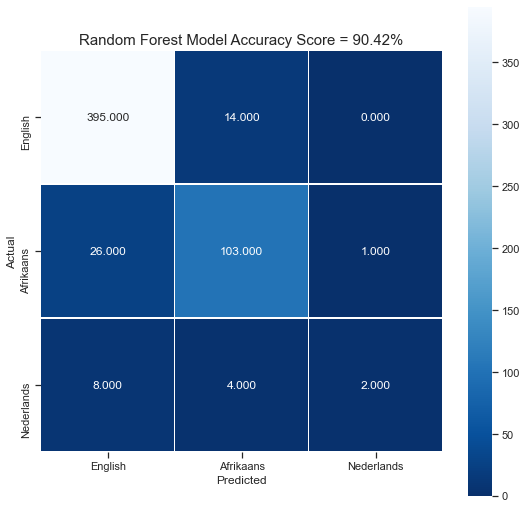

In [22]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(cm_Model_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
title = 'Random Forest Model Accuracy Score = '+ str(round(accuracy_score_rf*100,2)) +"%"
plt.title(title, size = 15)

### Precision, Recall, F-measure, and Support

In [23]:
print('Random Forest Model Output')
print(classification_report(y_test,y_pred))

Random Forest Model Output
              precision    recall  f1-score   support

   Afrikaans       0.85      0.79      0.82       130
     English       0.92      0.97      0.94       409
  Nederlands       0.67      0.14      0.24        14

    accuracy                           0.90       553
   macro avg       0.81      0.63      0.67       553
weighted avg       0.90      0.90      0.90       553



## Model 3: Gradient Boost 

- Boosting is a method of converting weak learners into strong learners.
- In boosting, each new tree is a fit on a modified version of the original data set.
- Gradient Boosting trains many models in a gradual, additive and sequential manner. 
- Gradient boosting identifies the model's shortcomings by using gradients in the loss function (y=ax+b+e). The loss function is a measure indicating how good are model’s coefficients at fitting the underlying data. 
- A main advantage of the gradient boost model is that it allows us to optimize a user-specified cost function instead of a loss function that gives less control and may not correspond with real world problems.

In [24]:
# I run the gradient boost model on several values for the learning rate
learning_rate = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for lr in learning_rate:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=lr)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", lr)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.906
Accuracy score (testing): 0.890

Learning rate:  0.075
Accuracy score (training): 0.918
Accuracy score (testing): 0.899

Learning rate:  0.1
Accuracy score (training): 0.930
Accuracy score (testing): 0.899

Learning rate:  0.25
Accuracy score (training): 0.966
Accuracy score (testing): 0.895

Learning rate:  0.5
Accuracy score (training): 0.982
Accuracy score (testing): 0.895

Learning rate:  0.75
Accuracy score (training): 0.989
Accuracy score (testing): 0.890

Learning rate:  1
Accuracy score (training): 0.991
Accuracy score (testing): 0.886



In [25]:
# Based on the above results, i use the learning_rate = 1 since it offers the highest accuracy score for the training set
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1)
gb_clf.fit(X_train, y_train)

# Save model to file in the current working directory so that it can be imported and used.
# I use the pickle library to save the parameters of the trained model
pkl_file = "gradient_boost_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(gb_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    gb_clf = pickle.load(file)

gb_clf # parameters of the Gradient Boost model are shown below

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
y_pred = gb_clf.predict(X_test)

## Measure Model Performance

### Accuracy

In [27]:
# Calculate accuracy of the Decision Tree Model
accuracy_score_gb = accuracy_score(y_test, y_pred)
print('Accuracy of the Decision Tree Model on the test set = ' + str(round(accuracy_score_gb*100,2)) +"%" )

Accuracy of the Decision Tree Model on the test set = 88.79%


### Confusion Matrix

In [28]:
labels = ['English', 'Afrikaans', 'Nederlands']
cm_Model_gb = confusion_matrix(y_test, y_pred, labels)

Text(0.5, 1.0, 'Gradient Boost Model Accuracy Score = 88.79%')

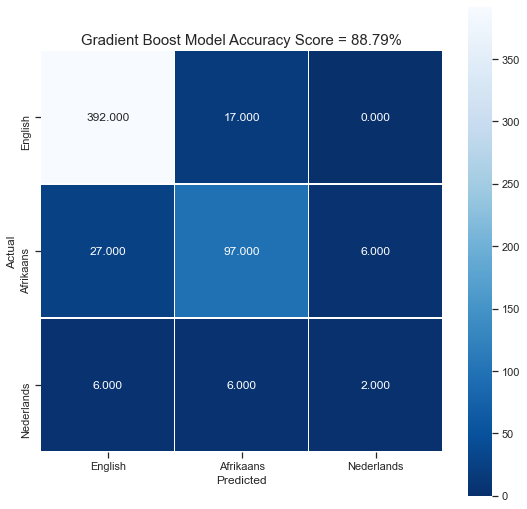

In [29]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(cm_Model_gb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
title = 'Gradient Boost Model Accuracy Score = '+ str(round(accuracy_score_gb*100,2)) +"%"
plt.title(title, size = 15)

### Precision, Recall, F-measure, and Support

In [30]:
print('Gradient Boost Model Output')
print(classification_report(y_test,y_pred))

Gradient Boost Model Output
              precision    recall  f1-score   support

   Afrikaans       0.81      0.75      0.78       130
     English       0.92      0.96      0.94       409
  Nederlands       0.25      0.14      0.18        14

    accuracy                           0.89       553
   macro avg       0.66      0.62      0.63       553
weighted avg       0.88      0.89      0.88       553



## Conclusion
- In general the classification model used based on a decision tree performs well with an overall accuracy of around 90%.
- Specifically, the model performs well for classifying English and Afrikaans given the high precision, recall and f1-scores for these two languages.
- The prediction of the model can be improved by using additional features and preprocessing that are geared more towards the Dutch language.
- Moreover, the sample used is not balanced as shown by the values of the support parameter in the table above. This means that there are very few observations pertaining to the Dutch language. Thus, a more balanced dataset may allow us to improve the model's predictive ability.